In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

tf.random.set_seed(1)

In [2]:
import plotly.express as px

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
X_train = X_train / 255
X_test = X_test / 255

In [5]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

## model

In [6]:
inputs = keras.Input(shape=(32,32,3), name='img')
x = layers.Conv2D(32,3, activation='relu')(inputs)
x = layers.Conv2D(64,3, activation='relu')(x)
block_1_output = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(64,3, activation='relu', padding='same')(block_1_output)
x = layers.Conv2D(64,3, activation='relu', padding='same')(x)
block_2_output = layers.add([x, block_1_output])
x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_2_output)
x = layers.Conv2D(64,3, activation='relu', padding='same')(x)
block_3_output = layers.add([x, block_2_output])
x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

In [7]:
model = keras.Model(inputs, outputs, name='toy_resnet')

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.fit(X_train, y_train, batch_size = 64, epochs=15, validation_split = 0.2)

Epoch 1/15
625/625 [==============================] - 68s 106ms/step - loss: 1.8080 - accuracy: 0.2898 - val_loss: 1.5366 - val_accuracy: 0.4131
Epoch 2/15
625/625 [==============================] - 72s 115ms/step - loss: 1.3508 - accuracy: 0.4962 - val_loss: 1.1645 - val_accuracy: 0.5723
Epoch 3/15
625/625 [==============================] - 68s 109ms/step - loss: 1.0945 - accuracy: 0.6053 - val_loss: 0.9937 - val_accuracy: 0.6348
Epoch 4/15
625/625 [==============================] - 61s 97ms/step - loss: 0.9631 - accuracy: 0.6544 - val_loss: 0.9162 - val_accuracy: 0.6700
Epoch 5/15
625/625 [==============================] - 64s 103ms/step - loss: 0.8608 - accuracy: 0.6932 - val_loss: 0.8521 - val_accuracy: 0.6939
Epoch 6/15
625/625 [==============================] - 62s 100ms/step - loss: 0.7796 - accuracy: 0.7234 - val_loss: 0.7787 - val_accuracy: 0.7288
Epoch 7/15
625/625 [==============================] - 59s 94ms/step - loss: 0.7081 - accuracy: 0.7522 - val_loss: 0.7691 - val_accu

In [10]:
print(model.evaluate(X_test, y_test))

313/313 [==============================] - 3s 10ms/step - loss: 0.7174 - accuracy: 0.7720
[0.7174496054649353, 0.7720000147819519]


## ШУмы и тд

In [11]:
import numpy as np

def add_noise(img, scale):
    '''Add random noise to an image'''
    noise = np.random.normal(loc=0, scale=scale, size=img.shape)
    img = img + noise
    img = np.clip(img, 0., 1.)
    return img

# Create a new generator
def image_generator_with_noise(images, labels, batch_size, scale=0.1):
    images = images.copy()
    labels = labels.copy()
    num_samples = len(images)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_images = images[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]
            
            # Add noise to the images
            batch_images_noisy = np.array([add_noise(img, scale) for img in batch_images])

            yield batch_images_noisy, batch_labels

# Use the new generator
batch_size = 64
test_generator_noisy = image_generator_with_noise(X_test, y_test, batch_size)

In [12]:
steps = X_test.shape[0] // batch_size
loss, acc = model.evaluate(test_generator_noisy, steps=steps)
print(f"Test accuracy: {acc*100}")

156/156 [==============================] - 3s 20ms/step - loss: 1.8455 - accuracy: 0.5095
Test accuracy: 50.95152258872986


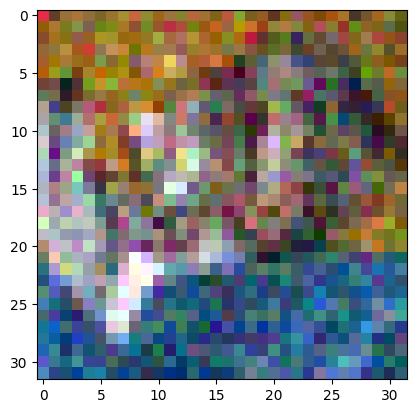

In [13]:
images_with_noise, labels = next(test_generator_noisy)

# Вывести первое изображение из батча
plt.imshow(images_with_noise[0])
plt.show()

## Coloring noise

In [14]:
def add_color_noise(img, scale=0.1):
    '''Add random noise to each color channel of an image'''
    noise_r = np.random.normal(loc=0, scale=scale, size=img[..., 0].shape)
    noise_g = np.random.normal(loc=0, scale=scale, size=img[..., 1].shape)
    noise_b = np.random.normal(loc=0, scale=scale, size=img[..., 2].shape)
    
    img[..., 0] = img[..., 0] + noise_r
    img[..., 1] = img[..., 1] + noise_g
    img[..., 2] = img[..., 2] + noise_b
    
    img = np.clip(img, 0., 1.)
    return img

# Create a new generator
def image_generator_with_color_noise(images, labels, batch_size, scale=0.1):
    images = images.copy()
    labels = labels.copy()
    num_samples = len(images)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_images = images[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]
            
            # Add noise to the images
            batch_images_noisy = np.array([add_color_noise(img, scale) for img in batch_images])

            yield batch_images_noisy, batch_labels

# Use the new generator
test_generator_color_noisy = image_generator_with_color_noise(X_test, y_test, batch_size)

In [15]:
steps = X_test.shape[0] // batch_size
loss, acc = model.evaluate(test_generator_color_noisy, steps=steps)
print(f"Test accuracy: {acc*100}")

156/156 [==============================] - 3s 20ms/step - loss: 1.8172 - accuracy: 0.5068
Test accuracy: 50.681090354919434


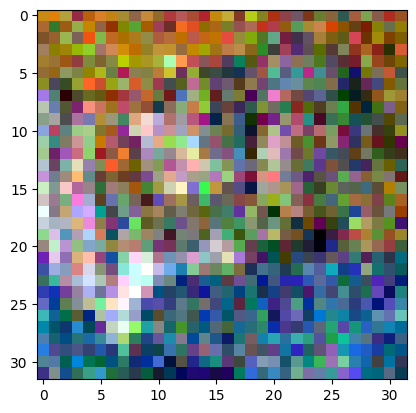

In [16]:
# Получить один батч изображений с шумом
images_with_color_noise, labels = next(test_generator_color_noisy)

# Вывести первое изображение из батча
plt.imshow(images_with_color_noise[0])
plt.show()

## Снег

In [17]:
def add_snow_effect(img, high):
    '''Add snow effect to an image'''
    snow_layer = np.random.poisson(lam=10., size=img.shape)
    snow_layer = snow_layer * np.random.randint(low=0, high=high, size=img.shape)
    snow_layer[snow_layer < 240] = 0

    img = img + snow_layer
    img = np.clip(img, 0., 1.)
    return img

# Create a new generator
def image_generator_with_snow(images, labels, batch_size, high=10):
    images = images.copy()
    labels = labels.copy()
    num_samples = len(images)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_images = images[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]
            
            # Add snow to the images
            batch_images_snowy = np.array([add_snow_effect(img, high) for img in batch_images])

            yield batch_images_snowy, batch_labels

# Use the new generator
test_generator_snowy = image_generator_with_snow(X_test, y_test, batch_size, 10)

In [18]:
steps = X_test.shape[0] // batch_size
loss, acc = model.evaluate(test_generator_snowy, steps=steps)
print(f"Test accuracy: {acc*100}")

156/156 [==============================] - 5s 33ms/step - loss: 0.7174 - accuracy: 0.7720
Test accuracy: 77.20352411270142


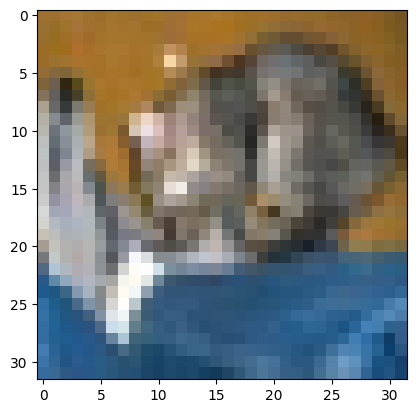

In [19]:
# Получить один батч изображений со снегом
images_with_snow, labels = next(test_generator_snowy)

# Вывести первое изображение из батча
plt.imshow(images_with_snow[0])
plt.show()

## Поворот на 30 градусов

In [20]:
from scipy.ndimage import rotate

def rotate_image(img, angle):
    '''Rotate an image by a certain angle'''
    img = rotate(img, angle=angle, reshape=False)
    return img

# Create a new generator
def image_generator_rotated(images, labels, batch_size, angle):
    images = images.copy()
    labels = labels.copy()
    num_samples = len(images)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_images = images[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]
            
            # Rotate the images
            batch_images_rotated = np.array([rotate_image(img, angle) for img in batch_images])

            yield batch_images_rotated, batch_labels

# Use the new generator with 30 degree rotation
test_generator_rotated = image_generator_rotated(X_test, y_test, batch_size, 30)

In [21]:
steps = X_test.shape[0] // batch_size
loss, acc = model.evaluate(test_generator_rotated, steps=steps)
print(f"Test accuracy: {acc*100}")

156/156 [==============================] - 6s 37ms/step - loss: 2.3149 - accuracy: 0.3895
Test accuracy: 38.95232379436493


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


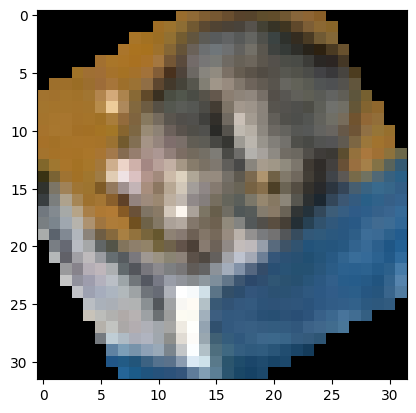

In [22]:
# Получить один батч изображений с поворотом
images_rotated, labels = next(test_generator_rotated)

# Вывести первое изображение из батча
plt.imshow(images_rotated[0])
plt.show()

## Графики

## Шум (белый)

In [23]:
def make_plot(scale_values, acc_values, name_plot):
    plt.plot(scale_values, acc_values)
    plt.title(name_plot)
    plt.ylabel("Accuracy")
    plt.xlabel("Scale");
    
    plt.locator_params (axis='x', nbins= len(scale_values))
    plt.locator_params (axis='y', nbins= len(acc_values))

In [33]:
scale_values = []
acc_values = []

    
while_scale = 0.1

while while_scale <= 1:
    scale_values.append(while_scale)
    test_generator_noisy = image_generator_with_noise(X_test, y_test, batch_size, scale=while_scale)

    steps = X_test.shape[0] // batch_size
    loss, acc = model.evaluate(test_generator_noisy, steps=steps)
    print(f"Test accuracy: {acc*100}")
    
    # Получить один батч изображений с шумом
    #images_with_color_noise, labels = next(test_generator_color_noisy)

    # Вывести первое изображение из батча
   # plt.imshow(images_with_color_noise[0])
   # plt.show()
    acc_values.append(acc*100)
    while_scale += 0.1
    

156/156 [==============================] - 4s 24ms/step - loss: 0.8624 - accuracy: 0.8164
Test accuracy: 81.640625
156/156 [==============================] - 4s 26ms/step - loss: 3.2630 - accuracy: 0.5503
Test accuracy: 55.02804517745972
156/156 [==============================] - 4s 28ms/step - loss: 6.0457 - accuracy: 0.3592
Test accuracy: 35.91746687889099
156/156 [==============================] - 4s 26ms/step - loss: 8.0593 - accuracy: 0.2518
Test accuracy: 25.180289149284363
156/156 [==============================] - 4s 26ms/step - loss: 9.4504 - accuracy: 0.1996
Test accuracy: 19.961939752101898
156/156 [==============================] - 4s 25ms/step - loss: 10.3823 - accuracy: 0.1732
Test accuracy: 17.31770783662796
156/156 [==============================] - 4s 25ms/step - loss: 10.9932 - accuracy: 0.1551
Test accuracy: 15.51482379436493
156/156 [==============================] - 4s 25ms/step - loss: 11.5546 - accuracy: 0.1475
Test accuracy: 14.753605425357819
156/156 [=========

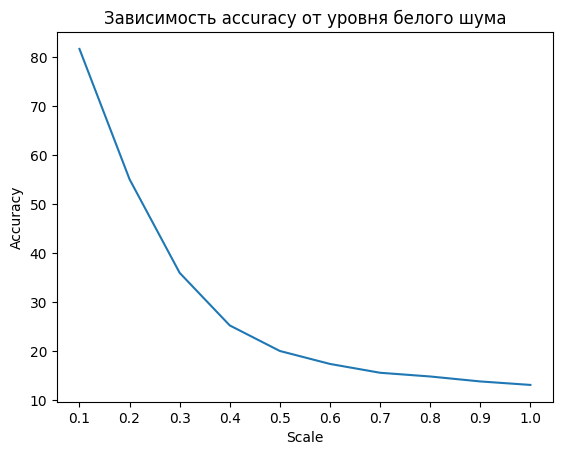

In [35]:
make_plot(scale_values, acc_values, "Зависимость accuracy от уровня белого шума")

## Цветной шум 

In [36]:
scale_values = []
acc_values = []

    
color_scale = 0.1

while color_scale <= 1:
    scale_values.append(color_scale)
    test_generator_color_noisy = image_generator_with_color_noise(X_test, y_test, batch_size, scale=color_scale)
    steps = X_test.shape[0] // batch_size
    loss, acc = model.evaluate(test_generator_color_noisy, steps=steps)
    print(f"Test accuracy: {acc*100}")
    
    acc_values.append(acc*100)
    color_scale += 0.1
    

156/156 [==============================] - 4s 26ms/step - loss: 0.8305 - accuracy: 0.8234
Test accuracy: 82.34174847602844
156/156 [==============================] - 4s 25ms/step - loss: 3.2911 - accuracy: 0.5491
Test accuracy: 54.90785241127014
156/156 [==============================] - 4s 26ms/step - loss: 6.0495 - accuracy: 0.3527
Test accuracy: 35.26642620563507
156/156 [==============================] - 4s 26ms/step - loss: 8.1100 - accuracy: 0.2481
Test accuracy: 24.809695780277252
156/156 [==============================] - 4s 27ms/step - loss: 9.4674 - accuracy: 0.2003
Test accuracy: 20.03205120563507
156/156 [==============================] - 4s 27ms/step - loss: 10.4272 - accuracy: 0.1726
Test accuracy: 17.257611453533173
156/156 [==============================] - 5s 33ms/step - loss: 11.0997 - accuracy: 0.1540
Test accuracy: 15.404647588729858
156/156 [==============================] - 5s 30ms/step - loss: 11.4592 - accuracy: 0.1457
Test accuracy: 14.573317766189575
156/156 [

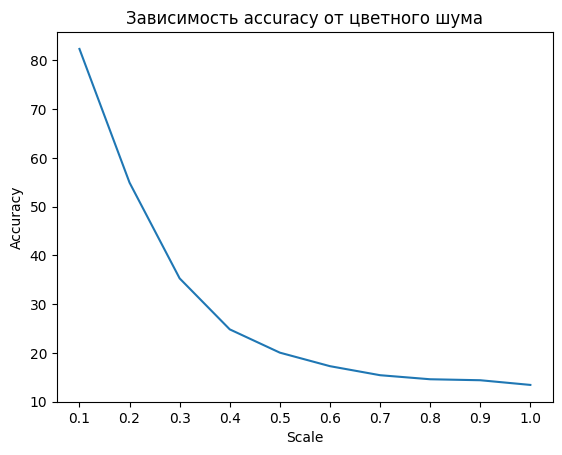

In [37]:
make_plot(scale_values, acc_values, "Зависимость accuracy от цветного шума")

## Снег

In [38]:
scale_values = []
acc_values = []

    
snowy=5

while snowy <= 100:
    test_generator_snowy = image_generator_with_snow(X_test, y_test, batch_size, snowy)
    steps = X_test.shape[0] // batch_size
    loss, acc = model.evaluate(test_generator_snowy, steps=steps)
    print(f"Test accuracy: {acc*100}")
    
    scale_values.append(snowy)
    acc_values.append(acc*100)
    snowy += 10

156/156 [==============================] - 7s 42ms/step - loss: 0.1782 - accuracy: 0.9480
Test accuracy: 94.80168223381042
156/156 [==============================] - 6s 37ms/step - loss: 0.1993 - accuracy: 0.9409
Test accuracy: 94.09054517745972
156/156 [==============================] - 7s 44ms/step - loss: 2.5383 - accuracy: 0.6364
Test accuracy: 63.641828298568726
156/156 [==============================] - 8s 50ms/step - loss: 5.2999 - accuracy: 0.4230
Test accuracy: 42.29767620563507
156/156 [==============================] - 7s 45ms/step - loss: 6.2582 - accuracy: 0.3518
Test accuracy: 35.17628312110901
156/156 [==============================] - 8s 48ms/step - loss: 6.3614 - accuracy: 0.3091
Test accuracy: 30.909454822540283
156/156 [==============================] - 7s 45ms/step - loss: 6.3102 - accuracy: 0.2823
Test accuracy: 28.225159645080566
156/156 [==============================] - 7s 45ms/step - loss: 6.2104 - accuracy: 0.2629
Test accuracy: 26.292067766189575
156/156 [===

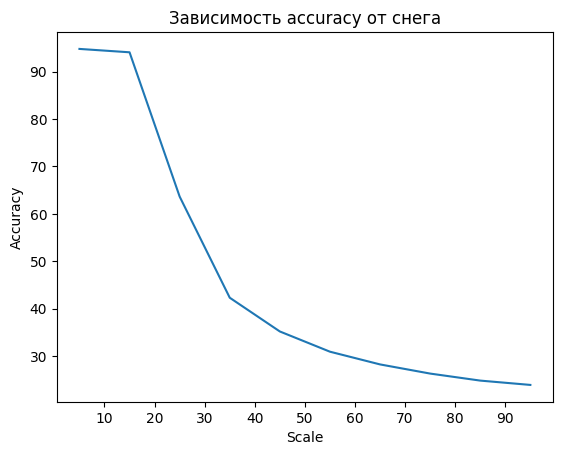

In [39]:
make_plot(scale_values, acc_values, "Зависимость accuracy от снега")

## Rotation

In [40]:
scale_values = []
acc_values = []

rotation = 0

while rotation <= 180:
    test_generator_rotated = image_generator_rotated(X_test, y_test, batch_size, rotation)

    steps = X_test.shape[0] // batch_size
    loss, acc = model.evaluate(test_generator_rotated, steps=steps)
    print(f"Test accuracy: {acc*100}")
    acc_values.append(acc*100)
    scale_values.append(rotation)
    rotation += 10

156/156 [==============================] - 7s 44ms/step - loss: 0.1782 - accuracy: 0.9480
Test accuracy: 94.80168223381042
156/156 [==============================] - 7s 48ms/step - loss: 0.3584 - accuracy: 0.9026
Test accuracy: 90.26442170143127
156/156 [==============================] - 6s 41ms/step - loss: 2.2515 - accuracy: 0.6333
Test accuracy: 63.33132982254028
156/156 [==============================] - 6s 41ms/step - loss: 4.7488 - accuracy: 0.4406
Test accuracy: 44.060495495796204
156/156 [==============================] - 7s 46ms/step - loss: 7.4095 - accuracy: 0.3150
Test accuracy: 31.500402092933655
156/156 [==============================] - 7s 46ms/step - loss: 8.6729 - accuracy: 0.2584
Test accuracy: 25.841346383094788
156/156 [==============================] - 7s 43ms/step - loss: 7.7398 - accuracy: 0.2498
Test accuracy: 24.97996836900711
156/156 [==============================] - 6s 41ms/step - loss: 7.7483 - accuracy: 0.2409
Test accuracy: 24.08854216337204
156/156 [====

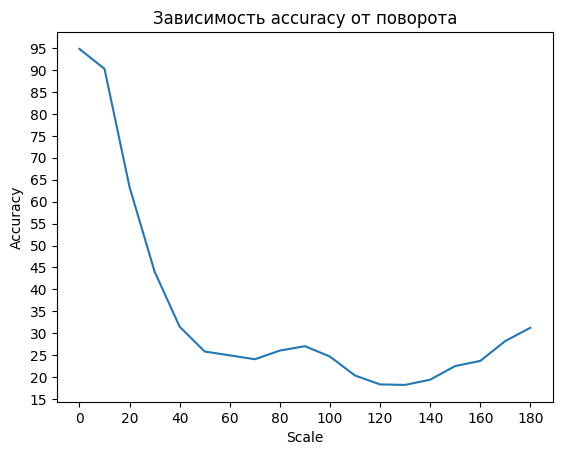

In [41]:
make_plot(scale_values, acc_values, "Зависимость accuracy от поворота")

# Дообучение

### Белый шум

In [24]:
scale_values = []
acc_values = []

    
while_scale = 0.1

while while_scale <= 0.6:
    scale_values.append(while_scale)
    test_generator_noisy = image_generator_with_noise(X_test, y_test, batch_size, scale=while_scale)
    
    # дообучение 
    train_generator_noisy = image_generator_with_noise(X_train, y_train, batch_size)
    steps_per_epoch = X_train.shape[0] // batch_size
    model.fit(train_generator_noisy, steps_per_epoch=steps_per_epoch, epochs=5)

    steps = X_test.shape[0] // batch_size
    loss, acc = model.evaluate(test_generator_noisy, steps=steps)
    print(f"Test accuracy: {acc*100}")
    
    acc_values.append(acc*100)
    while_scale += 0.5

Epoch 1/5
781/781 [==============================] - 76s 96ms/step - loss: 0.7328 - accuracy: 0.7460
Epoch 2/5
781/781 [==============================] - 72s 92ms/step - loss: 0.6546 - accuracy: 0.7699
Epoch 3/5
781/781 [==============================] - 72s 92ms/step - loss: 0.6355 - accuracy: 0.7806
Epoch 4/5
781/781 [==============================] - 72s 93ms/step - loss: 0.6179 - accuracy: 0.7853
Epoch 5/5
156/156 [==============================] - 3s 21ms/step - loss: 0.7938 - accuracy: 0.7359
Test accuracy: 73.58773946762085
Epoch 1/5
781/781 [==============================] - 72s 92ms/step - loss: 0.5763 - accuracy: 0.7991
Epoch 2/5
781/781 [==============================] - 72s 92ms/step - loss: 0.5625 - accuracy: 0.8044
Epoch 3/5
781/781 [==============================] - 73s 93ms/step - loss: 0.5489 - accuracy: 0.8073
Epoch 4/5
781/781 [==============================] - 74s 94ms/step - loss: 0.5389 - accuracy: 0.8112
Epoch 5/5
156/156 [==============================] - 3s 22m

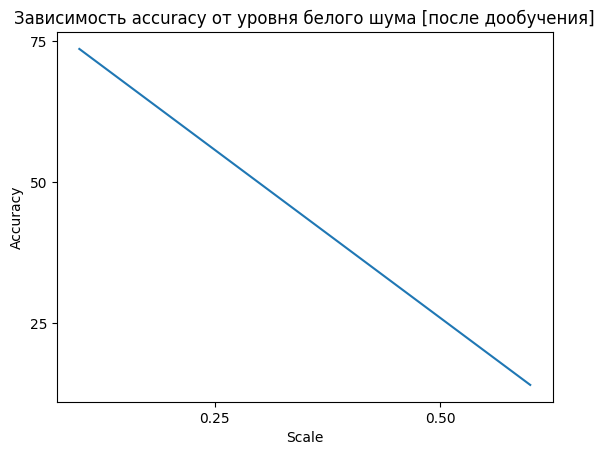

In [25]:
make_plot(scale_values, acc_values, "Зависимость accuracy от уровня белого шума [после дообучения]")

## Цветной шум

In [26]:
scale_values = []
acc_values = []

    
color_scale = 0.1

while color_scale <= 0.6:
    scale_values.append(color_scale)
    test_generator_color_noisy = image_generator_with_color_noise(X_test, y_test, batch_size, scale=color_scale)
    steps = X_test.shape[0] // batch_size
    loss, acc = model.evaluate(test_generator_color_noisy, steps=steps)
    
     # дообучение
    train_generator_noisy = image_generator_with_color_noise(X_train, y_train, batch_size)
    steps_per_epoch = X_train.shape[0] // batch_size
    model.fit(train_generator_noisy, steps_per_epoch=steps_per_epoch, epochs=5)
    print(f"Test accuracy: {acc*100}")
    
    acc_values.append(acc*100)
    color_scale += 0.5
    

156/156 [==============================] - 3s 22ms/step - loss: 0.8494 - accuracy: 0.7304
Epoch 1/5
781/781 [==============================] - 72s 92ms/step - loss: 0.5070 - accuracy: 0.8204
Epoch 2/5
781/781 [==============================] - 73s 93ms/step - loss: 0.6091 - accuracy: 0.7861
Epoch 3/5
781/781 [==============================] - 73s 93ms/step - loss: 0.6755 - accuracy: 0.7616
Epoch 4/5
781/781 [==============================] - 73s 93ms/step - loss: 0.7315 - accuracy: 0.7407
Epoch 5/5
781/781 [==============================] - 73s 93ms/step - loss: 0.7758 - accuracy: 0.7241
Test accuracy: 73.03686141967773
156/156 [==============================] - 3s 21ms/step - loss: 3.2052 - accuracy: 0.2381
Epoch 1/5
781/781 [==============================] - 73s 93ms/step - loss: 0.5112 - accuracy: 0.8219
Epoch 2/5
781/781 [==============================] - 73s 94ms/step - loss: 0.5666 - accuracy: 0.7997
Epoch 3/5
781/781 [==============================] - 72s 92ms/step - loss: 0.632

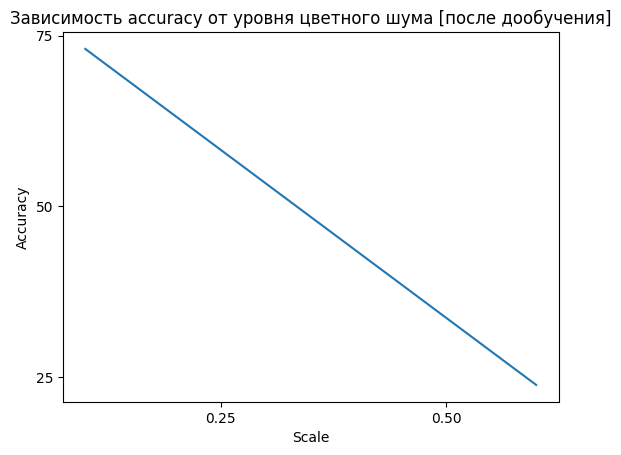

In [27]:
make_plot(scale_values, acc_values, "Зависимость accuracy от уровня цветного шума [после дообучения]")

## Снег дообучение

In [28]:
scale_values = []
acc_values = []

    
snowy=5

while snowy <= 60:
    test_generator_snowy = image_generator_with_snow(X_test, y_test, batch_size, snowy)
    steps = X_test.shape[0] // batch_size
    
    # дообучение
    train_generator_noisy = image_generator_with_snow(X_train, y_train, batch_size, snowy)
    steps_per_epoch = X_train.shape[0] // batch_size
    model.fit(test_generator_snowy, steps_per_epoch=steps_per_epoch, epochs=5)
    
    
    loss, acc = model.evaluate(test_generator_snowy, steps=steps)
    print(f"Test accuracy: {acc*100}")
    
    scale_values.append(snowy)
    acc_values.append(acc*100)
    snowy += 50

Epoch 1/5
781/781 [==============================] - 73s 93ms/step - loss: 0.4936 - accuracy: 0.8311
Epoch 2/5
781/781 [==============================] - 73s 93ms/step - loss: 0.2140 - accuracy: 0.9256
Epoch 3/5
781/781 [==============================] - 75s 95ms/step - loss: 0.1196 - accuracy: 0.9599
Epoch 4/5
781/781 [==============================] - 115s 148ms/step - loss: 0.0744 - accuracy: 0.9755
Epoch 5/5
156/156 [==============================] - 14s 88ms/step - loss: 0.0506 - accuracy: 0.9833
Test accuracy: 98.32930564880371
Epoch 1/5
781/781 [==============================] - 106s 135ms/step - loss: 1.7321 - accuracy: 0.3848
Epoch 2/5
781/781 [==============================] - 74s 94ms/step - loss: 1.4813 - accuracy: 0.4704
Epoch 3/5
781/781 [==============================] - 80s 103ms/step - loss: 1.3796 - accuracy: 0.5060
Epoch 4/5
781/781 [==============================] - 73s 93ms/step - loss: 1.3226 - accuracy: 0.5283
Epoch 5/5
156/156 [==============================] - 

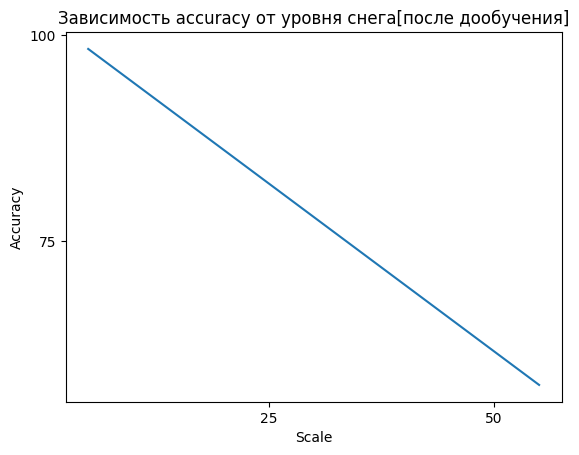

In [29]:
make_plot(scale_values, acc_values, "Зависимость accuracy от уровня снега[после дообучения]") 

## Rotation дообучение

In [30]:
scale_values = []
acc_values = []

rotation = 5

while rotation <= 5:
    test_generator_rotated = image_generator_rotated(X_test, y_test, batch_size, rotation)

    steps = X_test.shape[0] // batch_size
    
    train_generator_noisy = image_generator_rotated(X_train, y_train, batch_size, rotation)
    steps_per_epoch = X_train.shape[0] // batch_size
    model.fit(test_generator_rotated, steps_per_epoch=steps_per_epoch, epochs=5)
    
    loss, acc = model.evaluate(test_generator_rotated, steps=steps)
    print(f"Test accuracy: {acc*100}")
    acc_values.append(acc*100)
    scale_values.append(rotation)
    rotation += 90

Epoch 1/5
781/781 [==============================] - 77s 99ms/step - loss: 0.4014 - accuracy: 0.8595
Epoch 2/5
781/781 [==============================] - 79s 101ms/step - loss: 0.1190 - accuracy: 0.9595
Epoch 3/5
781/781 [==============================] - 85s 109ms/step - loss: 0.0724 - accuracy: 0.9777
Epoch 4/5
781/781 [==============================] - 78s 100ms/step - loss: 0.0526 - accuracy: 0.9837
Epoch 5/5
156/156 [==============================] - 6s 38ms/step - loss: 0.0494 - accuracy: 0.9847
Test accuracy: 98.47021102905273


In [31]:
model.save_weights('after_dolearning_rnet.h5')

In [ ]:
model.load_weights('rnet.h5')

## Шум + поворот

In [32]:
def image_generator_with_noise_and_rotation(images, labels, batch_size, scale=0.1, angle=30):
    images = images.copy()
    labels = labels.copy()
    num_samples = len(images)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_images = images[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]

            # Add noise and rotate the images
            batch_images_processed = np.array([rotate_image(add_noise(img, scale), angle) for img in batch_images])

            yield batch_images_processed, batch_labels

# Use the new generator
test_generator_noisy_and_rotated = image_generator_with_noise_and_rotation(X_test, y_test, batch_size)

In [78]:
scale_values = []
rotation_values = []
acc_values = []

rotation_test_values = [30, 25, 20, 15, 10, 9, 8, 7, 5, 3, 2, 1]
scale_test_values = [1, 0.9, 0.7, 0.8, 0.65, 0.55, 0.5, 0.3, 0.16, 0.14, 0.1, 0.05]


rotation = rotation_test_values.pop()
scale = scale_test_values.pop()

tmp_value = 0

while len(rotation_test_values) != 0:
    test_generator_rotated = image_generator_with_noise_and_rotation(X_test, y_test, batch_size, scale, rotation)

    steps = X_test.shape[0] // batch_size
    
    
    loss, acc = model.evaluate(test_generator_rotated, steps=steps)
    print(f"Test accuracy: {acc*100}")
    acc_values.append(acc*100)
    scale_values.append(scale)
    rotation_values.append(rotation)
    
    rotation = rotation_test_values.pop()
    scale = scale_test_values.pop()

156/156 [==============================] - 7s 43ms/step - loss: 0.2131 - accuracy: 0.9346
Test accuracy: 93.45953464508057
156/156 [==============================] - 7s 44ms/step - loss: 0.5357 - accuracy: 0.8626
Test accuracy: 86.25801205635071
156/156 [==============================] - 7s 45ms/step - loss: 1.1432 - accuracy: 0.7559
Test accuracy: 75.59094429016113
156/156 [==============================] - 7s 46ms/step - loss: 1.5722 - accuracy: 0.6928
Test accuracy: 69.28085088729858
156/156 [==============================] - 7s 45ms/step - loss: 4.8357 - accuracy: 0.3685
Test accuracy: 36.84895932674408
156/156 [==============================] - 7s 45ms/step - loss: 7.6997 - accuracy: 0.2041
Test accuracy: 20.412659645080566
156/156 [==============================] - 7s 45ms/step - loss: 8.0710 - accuracy: 0.1868
Test accuracy: 18.679888546466827
156/156 [==============================] - 7s 45ms/step - loss: 8.7948 - accuracy: 0.1556
Test accuracy: 15.564903616905212
156/156 [====

In [33]:
model.save_weights('plus_rotation_after_dolearning_rnet.h5')

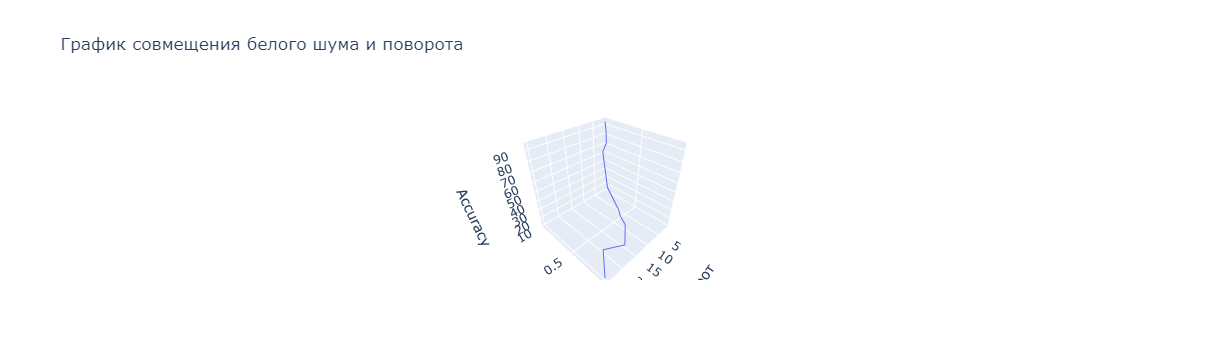

In [79]:
fig = px.line_3d(x=rotation_values,
                 y=scale_values, 
                 z=acc_values,
                 labels = {'x':'Поворот',
                          'y':'Шум',
                          'z': 'Accuracy'},
                title='График совмещения белого шума и поворота')
fig.show()

In [80]:
why_df

,accuracy,rotation,scale
0,93.719953,1,0.05
1,87.029248,3,0.10
2,37.049279,5,0.30
3,24.228767,10,0.40
4,17.417869,15,0.50


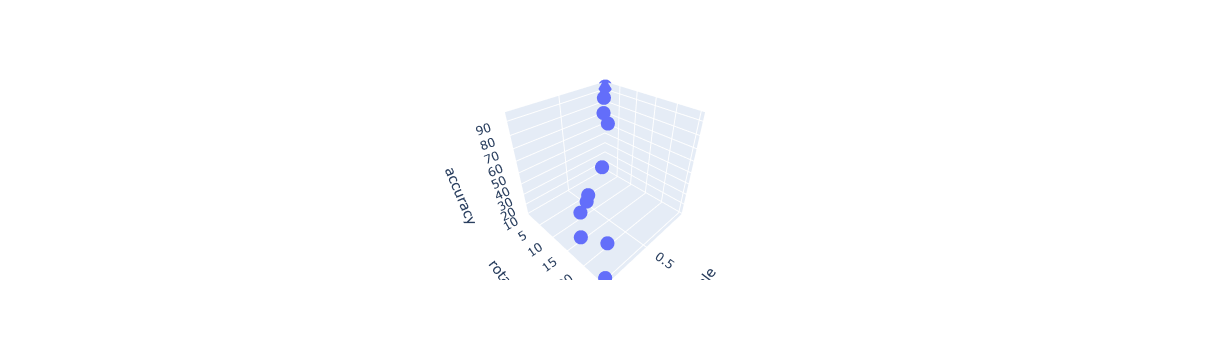

In [81]:
#fig = plt.figure()
#ax = plt.axes(projection='3d')
zipped = list(zip(acc_values, rotation_values, scale_values))

why_df = pd.DataFrame(zipped, columns=['accuracy', 'rotation', 'scale'])
# ax.scatter3D(why_df)
# plt.show()
px.scatter_3d(why_df, x='scale', y='rotation', z='accuracy')

In [82]:
why_df

,accuracy,rotation,scale
0,93.459535,1,0.05
1,86.258012,2,0.10
2,75.590944,3,0.14
3,69.280851,5,0.16
4,36.848959,7,0.30
5,20.412660,8,0.50
6,18.679889,9,0.55
7,15.564904,10,0.65
8,13.040866,15,0.80
9,12.970753,20,0.70


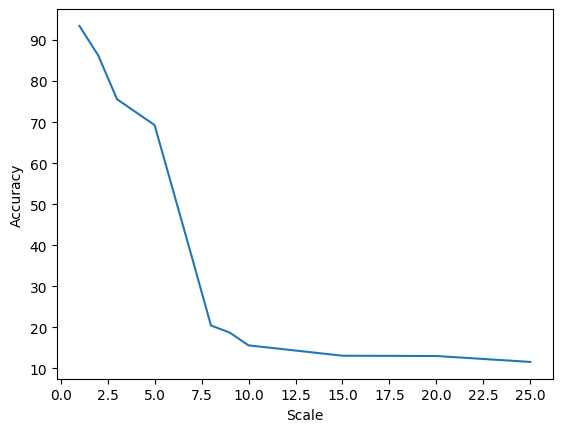

In [83]:
make_plot(rotation_values, acc_values, '')

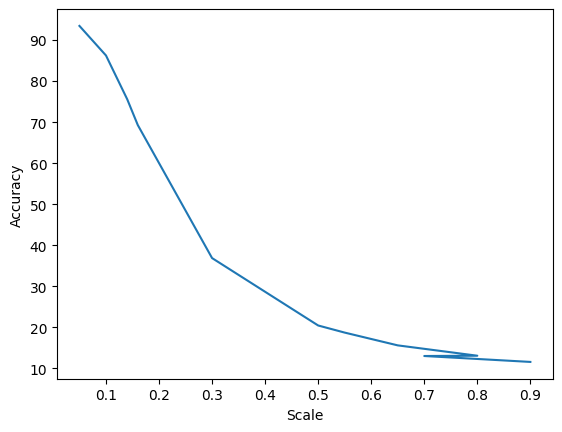

In [84]:
make_plot(scale_values, acc_values, '')

In [ ]:
model.load_weights('rnet.h5')

## Графики после дообучения:

## Белый шум

In [ ]:
scale_values = []
acc_values = []

    
while_scale = 0.1

while while_scale <= 1:
    scale_values.append(while_scale)
    test_generator_noisy = image_generator_with_noise(X_test, y_test, batch_size, scale=while_scale)

    steps = X_test.shape[0] // batch_size
    loss, acc = model.evaluate(test_generator_noisy, steps=steps)
    print(f"Test accuracy: {acc*100}")
    
    # Получить один батч изображений с шумом
    #images_with_color_noise, labels = next(test_generator_color_noisy)

    # Вывести первое изображение из батча
   # plt.imshow(images_with_color_noise[0])
   # plt.show()
    acc_values.append(acc*100)
    while_scale += 0.1
    

In [ ]:
make_plot(scale_values, acc_values, "Зависимость accuracy от белого шума[после дообучения]") 